### In this notebook, we apply `popsed` to NSA photometry catalog.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os, sys
import pickle
import corner
import numpy as np
from tqdm import trange
import matplotlib.pyplot as plt

import torch
from torch import nn, Tensor, optim, FloatTensor
from torch.distributions import MultivariateNormal
from geomloss import SamplesLoss
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

os.chdir('/scratch/gpfs/jiaxuanl/Data/popsed/')
sys.path.append('/home/jiaxuanl/Research/popsed/')
from popsed.speculator import SuperSpeculator, StandardScaler
import popsed
# popsed.set_matplotlib(style='JL', usetex=False, dpi=80)
from popsed import prior

Input parameters : logmstar, kappa1_sfh, kappa2_sfh, kappa3_sfh, fburst, tburst, logzsol, dust1, dust2, dust_index, redshift


**Input parameters : logmstar, InvSigmoid(kappa1_sfh), InvSigmoid(kappa2_sfh), InvSigmoid(kappa3_sfh), log10(fburst), log10(tburst), logzsol, log10(dust1), log10(dust2), dust_index, log10(redshift)**

We still need penalty on logzsol and dust_index

(10 params)

beta1_sfh, beta2_sfh, beta3_sfh, beta4_sfh = Transform(kappa1_sfh, kappa2_sfh, kappa3_sfh)

In [5]:
wave = np.load('./train_sed_NMF/nmf_seds/fsps.wavelength.npy')
speculator = SuperSpeculator(
    speculators_dir=[f'./train_sed_NMF/best_emu/speculator_best_recon_model_NMF.emu_{i_bin}.pkl' for i_bin in range(0, 5)], 
    str_wbin=[
              '.w1000_2000',
              '.w2000_3600', 
              '.w3600_5500', 
              '.w5500_7410', 
              '.w7410_60000'],
    wavelength=wave, 
    params_name=['kappa1_sfh', 'kappa2_sfh', 'kappa3_sfh', 
                 'fburst', 'tburst', 'logzsol', 'dust1', 'dust2', 
                 'dust_index', 'redshift', 'logm'], 
    device='cuda')

filters = ['sdss_{0}0'.format(b) for b in 'ugriz']
noise = 'nsa'
noise_model_dir = './noise_model/nsa_noise_model_mag.npy'

#### Load NSA photometry catalog

In [6]:
from astropy.table import Table
from popsed.utils import flux2mag, sigma_flux2mag

In [13]:
nsa_cat = Table.read('./reference_catalog/nsa_cleaned.fits')

In [18]:
flux_nsa = nsa_cat['ELPETRO_NMGY'][:,2:]
ivar_nsa = nsa_cat['ELPETRO_NMGY_IVAR'][:,2:]

# # zred_nsa = nsa_cat['Z']

mags_nsa = flux2mag(flux_nsa).data.data
sigs_nsa = sigma_flux2mag(ivar_nsa**-0.5, flux_nsa).data.data
snrs_nsa = flux_nsa.data.data * ivar_nsa.data.data**0.5

# flag = np.all((mags_nsa > 0) & (mags_nsa < 22), axis=1) # good photometry
# print('Number of bad photometry:', np.sum(~flag))
# mags_nsa = mags_nsa[flag]
# snrs_nsa = snrs_nsa[flag]

flag = np.all(snrs_nsa > 2, axis=1)
print('Number of bad photometry:', np.sum(~flag))
mags_nsa = mags_nsa[flag]
snrs_nsa = snrs_nsa[flag]

Number of bad photometry: 1911


In [19]:
X_data = torch.Tensor(mags_nsa)
#X_data = X_data[np.random.choice(np.arange(len(X_data)), 100000)]
print('Total number of samples:', len(X_data))

Total number of samples: 30041


kappa1_sfh, kappa2_sfh, kappa3_sfh, fburst, tburst, logzsol, dust1, dust2, dust_index, redshif, logmstar, 

In [20]:
filters = ['sdss_{0}0'.format(b) for b in 'ugriz']
noise = 'nsa'
noise_model_dir = './noise_model/nsa_noise_model_mag.npy'

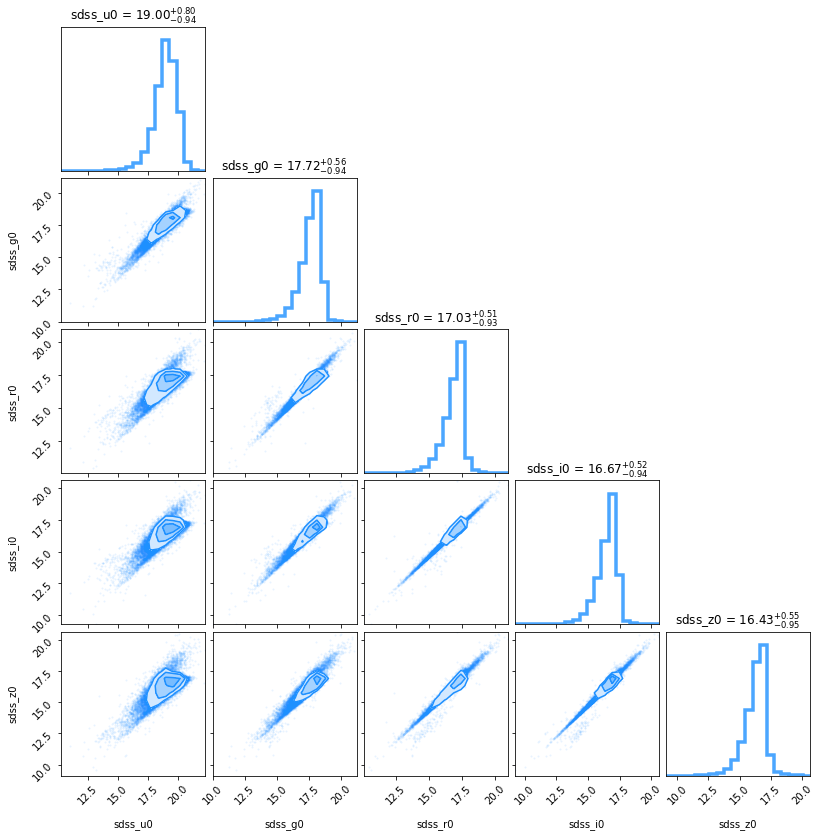

In [21]:
import matplotlib.lines as mlines
k_line = mlines.Line2D([], [], color='k', label='Noise-less photometry')
b_line = mlines.Line2D([], [], color='dodgerblue', label=r'Noisy photometry')

labels = filters # [f'sdss\_{f}0' for f in 'ugriz']

figure = corner.corner(X_data.cpu().detach().numpy()[:, :], 
                       color='dodgerblue', labels=labels,
                       #quantiles=[0.16, 0.5, 0.84], 
                       smooth=0.1, fill_contours=True,
                       show_titles=True, 
                       title_kwargs={"fontsize": 12},
                       hist_kwargs={'density': True})

# ax = nf_plot.get_axes()[4]
# ax.legend(handles=[k_line, b_line], fontsize=15)#, bbox_to_anchor=(0., 1.0, 1., .0))

In [23]:
X_train, X_vali = train_test_split(X_data, test_size=0.1)

kappa1_sfh, kappa2_sfh, kappa3_sfh, fburst, tburst, logzsol, dust1, dust2, dust_index, redshift, logmstar

In [24]:
from popsed.speculator import StandardScaler
from popsed.nde import WassersteinNeuralDensityEstimator
from geomloss import SamplesLoss

seed = 30
np.random.seed(seed)

_bounds = speculator.bounds.copy()
for i in range(3):
    _bounds[i] = [0.1, 0.9]

_bounds[6:8] = [1e-2, 3]
_bounds[3] = [0.001, 0.999] # fburst
_bounds[-2] = [1e-3, 0.5] # redshift
_bounds[-1] = [7, 13] # log_m


NDE_theta = WassersteinNeuralDensityEstimator(method='nsf',
                                              name='NMF',
                                              num_transforms=15,  # 10
                                              num_bins=10,  # how smashed it is. 10
                                              hidden_features=50,  # 120,
                                              seed=seed,
                                              output_dir=None,
                                              initial_pos={'bounds': _bounds,
                                                           'std': [0.3, 0.3, 0.3,  # sfh
                                                                   0.3, 5,  # burst
                                                                   0.5,  # logzsol
                                                                   0.6, 0.6, 0.6,  # dust
                                                                   0.2, 0.6],  # redshift and log_m
                                                           },
                                              normalize=False,
                                              regularize=False,
                                             )
Y_train = torch.ones(len(X_train), 11)
NDE_theta.build(
    Y_train,
    X_train,
    filterset=filters,
    optimizer='adam')
NDE_theta.load_validation_data(X_vali)
NDE_theta.bounds = speculator.bounds
NDE_theta.params_name = speculator.params_name

print('Total number of params in the model:', 
      sum(p.numel() for p in NDE_theta.net.parameters() if p.requires_grad))

[ 0.61531483  0.40459879  0.63043832  0.16432342 12.77417961 -1.59468066
  2.97533547  0.71282311 -0.65722293  0.20393836  7.81740593]
Total number of params in the model: 282587


In [25]:
max_epochs = 6
scheduler = torch.optim.lr_scheduler.OneCycleLR(NDE_theta.optimizer,
                                                max_lr=2e-3,
                                                steps_per_epoch=100,
                                                epochs=max_epochs)
for epoch in range(2):
    print('    Epoch {0}'.format(epoch))
    print('    lr:', NDE_theta.optimizer.param_groups[0]['lr'])
    NDE_theta.train(n_epochs=100,
                    speculator=speculator,
                    only_penalty=False,
                    noise=noise, noise_model_dir=noise_model_dir,
                    sinkhorn_kwargs={
                        'p': 1, 'blur': 0.1, 'scaling': 0.8},
                    scheduler=scheduler
                    )

scheduler = torch.optim.lr_scheduler.OneCycleLR(NDE_theta.optimizer,
                                                max_lr=1e-4, 
                                                steps_per_epoch=100, 
                                                epochs=max_epochs)
for epoch in range(max_epochs):
    print('lr:', NDE_theta.optimizer.param_groups[0]['lr'])
    NDE_theta.train(n_epochs=100, #50 if epoch==0 else 100,
                speculator=speculator, 
                only_penalty=False if epoch==0 else False,
                noise=noise, noise_model_dir=noise_model_dir,
                sinkhorn_kwargs={'p': 1, 'blur': 0.1, 'scaling': 0.8},
                scheduler=scheduler
               )

    Epoch 0
    lr: 7.999999999999999e-05


Loss = 0.673 (train), 0.858 (vali), 0.272 (bad ratio): 100%|███████████████████████████████████████████████| 100/100 [01:47<00:00,  1.08s/epochs]


    Epoch 1
    lr: 0.0012159123994228515


Loss = 0.129 (train), 0.406 (vali), 0.000 (bad ratio): 100%|███████████████████████████████████████████████| 100/100 [01:39<00:00,  1.01epochs/s]


lr: 4.000000000000002e-06


Loss = 0.121 (train), 0.340 (vali), 0.000 (bad ratio): 100%|███████████████████████████████████████████████| 100/100 [01:39<00:00,  1.00epochs/s]


lr: 6.079561997114258e-05


Loss = 0.121 (train), 0.343 (vali), 0.001 (bad ratio): 100%|███████████████████████████████████████████████| 100/100 [01:39<00:00,  1.00epochs/s]


lr: 9.938441949208878e-05


Loss = 0.136 (train), 0.411 (vali), 0.007 (bad ratio): 100%|███████████████████████████████████████████████| 100/100 [01:42<00:00,  1.02s/epochs]


lr: 8.08812928996152e-05


Loss = 0.140 (train), 0.353 (vali), 0.005 (bad ratio): 100%|███████████████████████████████████████████████| 100/100 [01:41<00:00,  1.02s/epochs]


lr: 4.589086641633858e-05


Loss = 0.122 (train), 0.477 (vali), 0.009 (bad ratio): 100%|███████████████████████████████████████████████| 100/100 [01:39<00:00,  1.01epochs/s]


lr: 1.309439774943247e-05


Loss = 0.114 (train), 0.385 (vali), 0.000 (bad ratio):  87%|█████████████████████████████████████████▊      | 87/100 [01:26<00:12,  1.00epochs/s]


KeyboardInterrupt: 

In [26]:
torch.cuda.empty_cache()

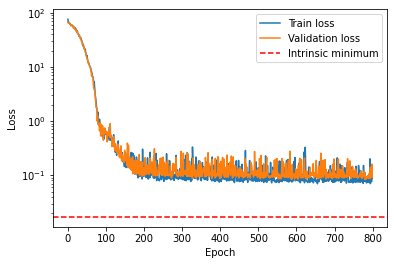

In [26]:
NDE_theta.plot_loss()
plt.yscale('log')

In [27]:
NDE_theta.vali_loss_history[-1]

0.09166125953197479

In [28]:
print('Best epoch:', NDE_theta.best_loss_epoch)
print('Best train loss:', NDE_theta.train_loss_history[NDE_theta.best_loss_epoch - 1])
print('Best vali loss:', NDE_theta.vali_loss_history[NDE_theta.best_loss_epoch - 1])

# NDE_theta.best_model.goodness_of_fit(Y_truth, p=1)
# NDE_theta.goodness_of_fit(Y_truth, p=1)

Best epoch: 783
Best train loss: 0.09331229329109192
Best vali loss: 0.08394776284694672


In [29]:
# sample the initial setups
_init_sample = []

_mean = NDE_theta.mean_init
_stds = NDE_theta.initial_pos['std']
_init_sample.append(np.random.normal(_mean, _stds, size=(1000, 11)))

_init_sample = np.array(_init_sample).reshape(-1, 11)

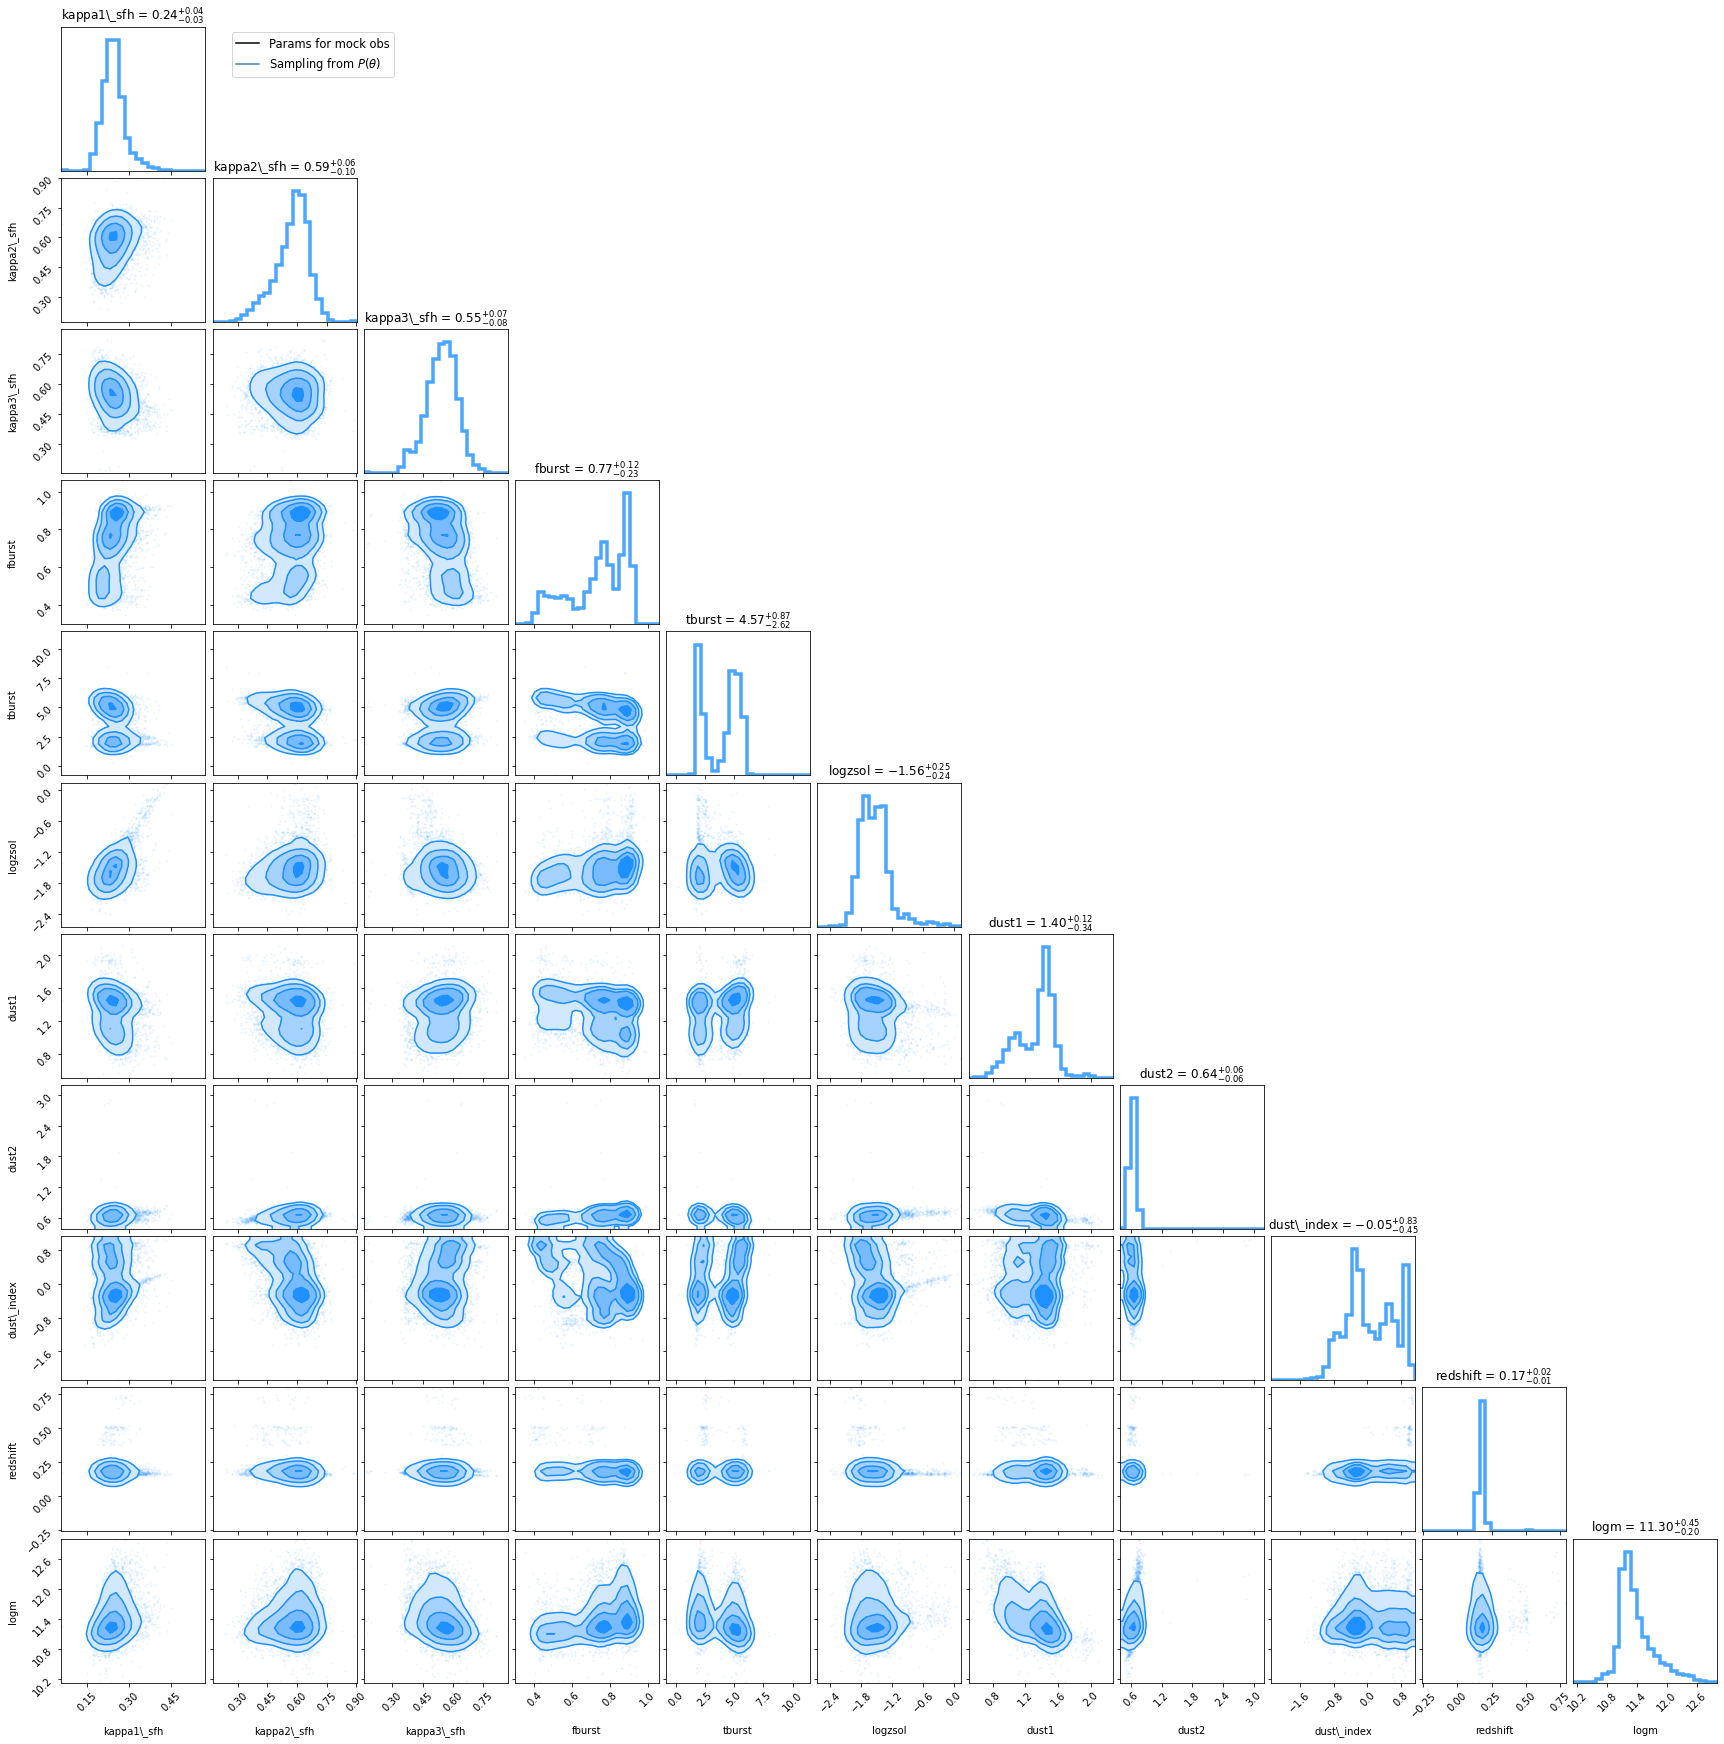

In [30]:
samples = NDE_theta.sample(5000)
import matplotlib.lines as mlines
k_line = mlines.Line2D([], [], color='k', label='Params for mock obs')
b_line = mlines.Line2D([], [], color='steelblue', label=r'Sampling from $P(\theta)$')

labels = [key.replace('_', '\_') for key in speculator.params_name]

# figure = corner.corner(Y_truth.cpu().detach().numpy(), 
#                        color='dimgray', labels=labels, bins=25,
#                        smooth=1, fill_contours=True,
#                        show_titles=True, title_kwargs={"fontsize": 12}, 
#                        hist_kwargs={'density': True})

nf_plot = corner.corner(samples.cpu().detach().numpy(), 
#                   fig=figure, 
                        labels=labels, bins=25,
                  color='dodgerblue',
                  smooth=1, fill_contours=True,
                  show_titles=True, title_kwargs={"fontsize": 12}, 
                        hist_kwargs={'density': True})

# _ = corner.corner(_init_sample, 
#                    fig=figure, color='salmon', alpha=0.1, labels=labels, bins=25,
#                    #quantiles=[0.16, 0.5, 0.84], 
#                    smooth=0.8, fill_contours=True,
#                    show_titles=True, 
#                    hist_kwargs={'density': True, 'lw': 0.5}, 
#                    title_kwargs={"fontsize": 12},
#                    plot_datapoints=True)

ax = nf_plot.get_axes()[1]
ax.legend(handles=[k_line, b_line], fontsize=11.5, bbox_to_anchor=(0., 1.0, 1.3, .0))

In [21]:
# samples = NDE_theta.sample(5000)
# import matplotlib.lines as mlines
# k_line = mlines.Line2D([], [], color='k', label='Params for mock obs')
# b_line = mlines.Line2D([], [], color='steelblue', label=r'Sampling from $P(\theta)$')

# labels = [key.replace('_', '\_') for key in speculator.params_name]

# figure = corner.corner(Y_truth.cpu().detach().numpy(), 
#                        color='dimgray', labels=labels, bins=25,
#                        #quantiles=[0.16, 0.5, 0.84], 
#                        smooth=1, fill_contours=True,
#                        show_titles=True, title_kwargs={"fontsize": 12}, 
#                        hist_kwargs={'density': True})

# nf_plot = corner.corner(inverse_transform_nmf_params(samples).cpu().detach().numpy(), 
#                   fig=figure, labels=labels, bins=25,
#                   color='dodgerblue', #quantiles=[0.16, 0.5, 0.84], 
#                   smooth=1, fill_contours=True,
#                   show_titles=True, title_kwargs={"fontsize": 12}, 
#                         hist_kwargs={'density': True})

# ax = nf_plot.get_axes()[1]
# ax.legend(handles=[k_line, b_line], fontsize=11.5, bbox_to_anchor=(0., 1.0, 1.3, .0))

0 5000
>40 0


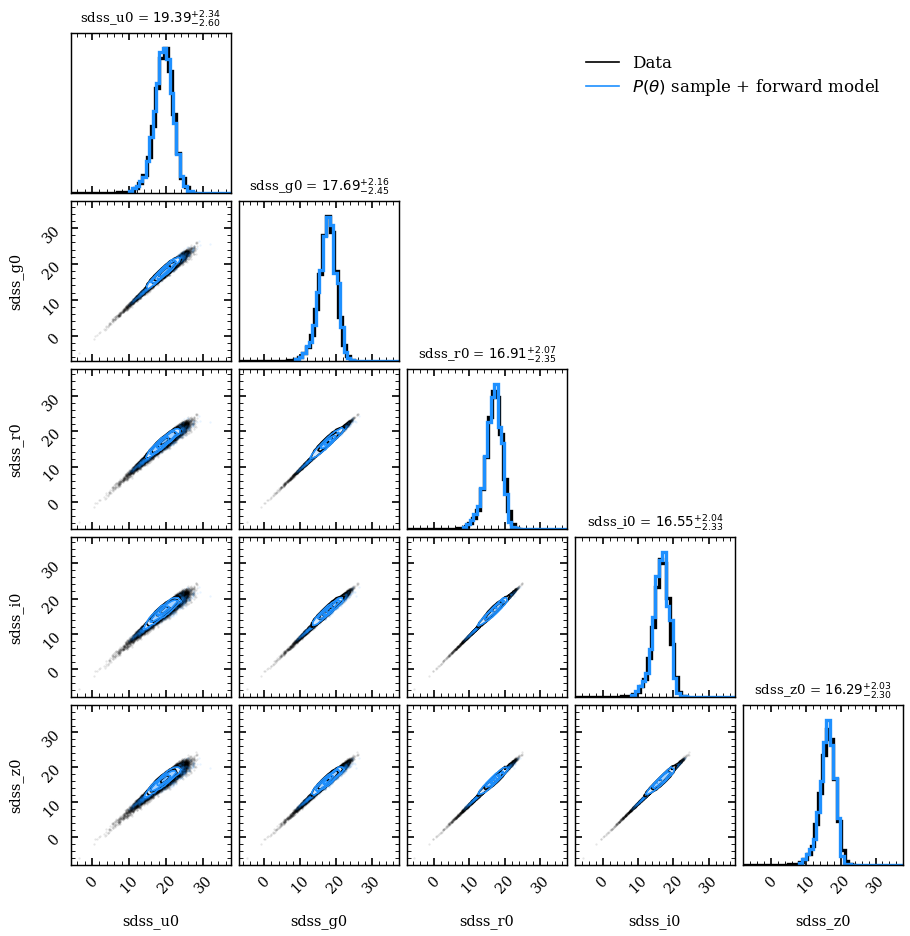

In [22]:
import matplotlib.lines as mlines
k_line = mlines.Line2D([], [], color='k', label='Data')
#r_line = mlines.Line2D([], [], color='tomato', label='NDE for the data')
b_line = mlines.Line2D([], [], color='dodgerblue', label=r'$P(\theta)$ sample + forward model')

labels = filters

figure = corner.corner(X_data.cpu().detach().numpy(), 
                       color='k', labels=labels, bins=30,
                       #quantiles=[0.16, 0.5, 0.84], 
                       smooth=0.4, fill_contours=True,
                       show_titles=True, 
                       title_kwargs={"fontsize": 12}, 
                       hist_kwargs={'density': True})

mags = speculator._predict_mag_with_mass_redshift(samples,#inverse_transform_nmf_params(samples),
                                                  filterset=filters,
                                                  noise=noise,
                                                  noise_model_dir=noise_model_dir,
                                                  ).cpu().detach().numpy()
print(np.isnan(mags).any(axis=1).sum(), len(mags))
print('>40', np.any(mags > 40, axis=1).sum())
mags = mags[~(np.isinf(mags).any(axis=1)| np.isnan(mags).any(axis=1))]
mags = mags[~np.any(mags > 40, axis=1)]
nf_plot = corner.corner(mags, 
                  fig=figure, labels=labels, bins=30,
                        #range=[[14, 25]] * 5,
                  color='dodgerblue', #quantiles=[0.16, 0.5, 0.84], 
                  smooth=0.4, fill_contours=True,
                  show_titles=False, 
                        title_kwargs={"fontsize": 12}, 
                       hist_kwargs={'density': True})

ax = nf_plot.get_axes()[4]
ax.legend(handles=[k_line, b_line], fontsize=15)#, bbox_to_anchor=(0., 1.0, 1., .0))

In [166]:
_samples_unt = inverse_transform_nmf_params(samples).detach().cpu().numpy()
_samples = np.hstack([_samples_unt[:, -1:], 
               prior.FlatDirichletPrior(4).transform(_samples_unt[:, :3]), 
               _samples_unt[:, 3:-1]])

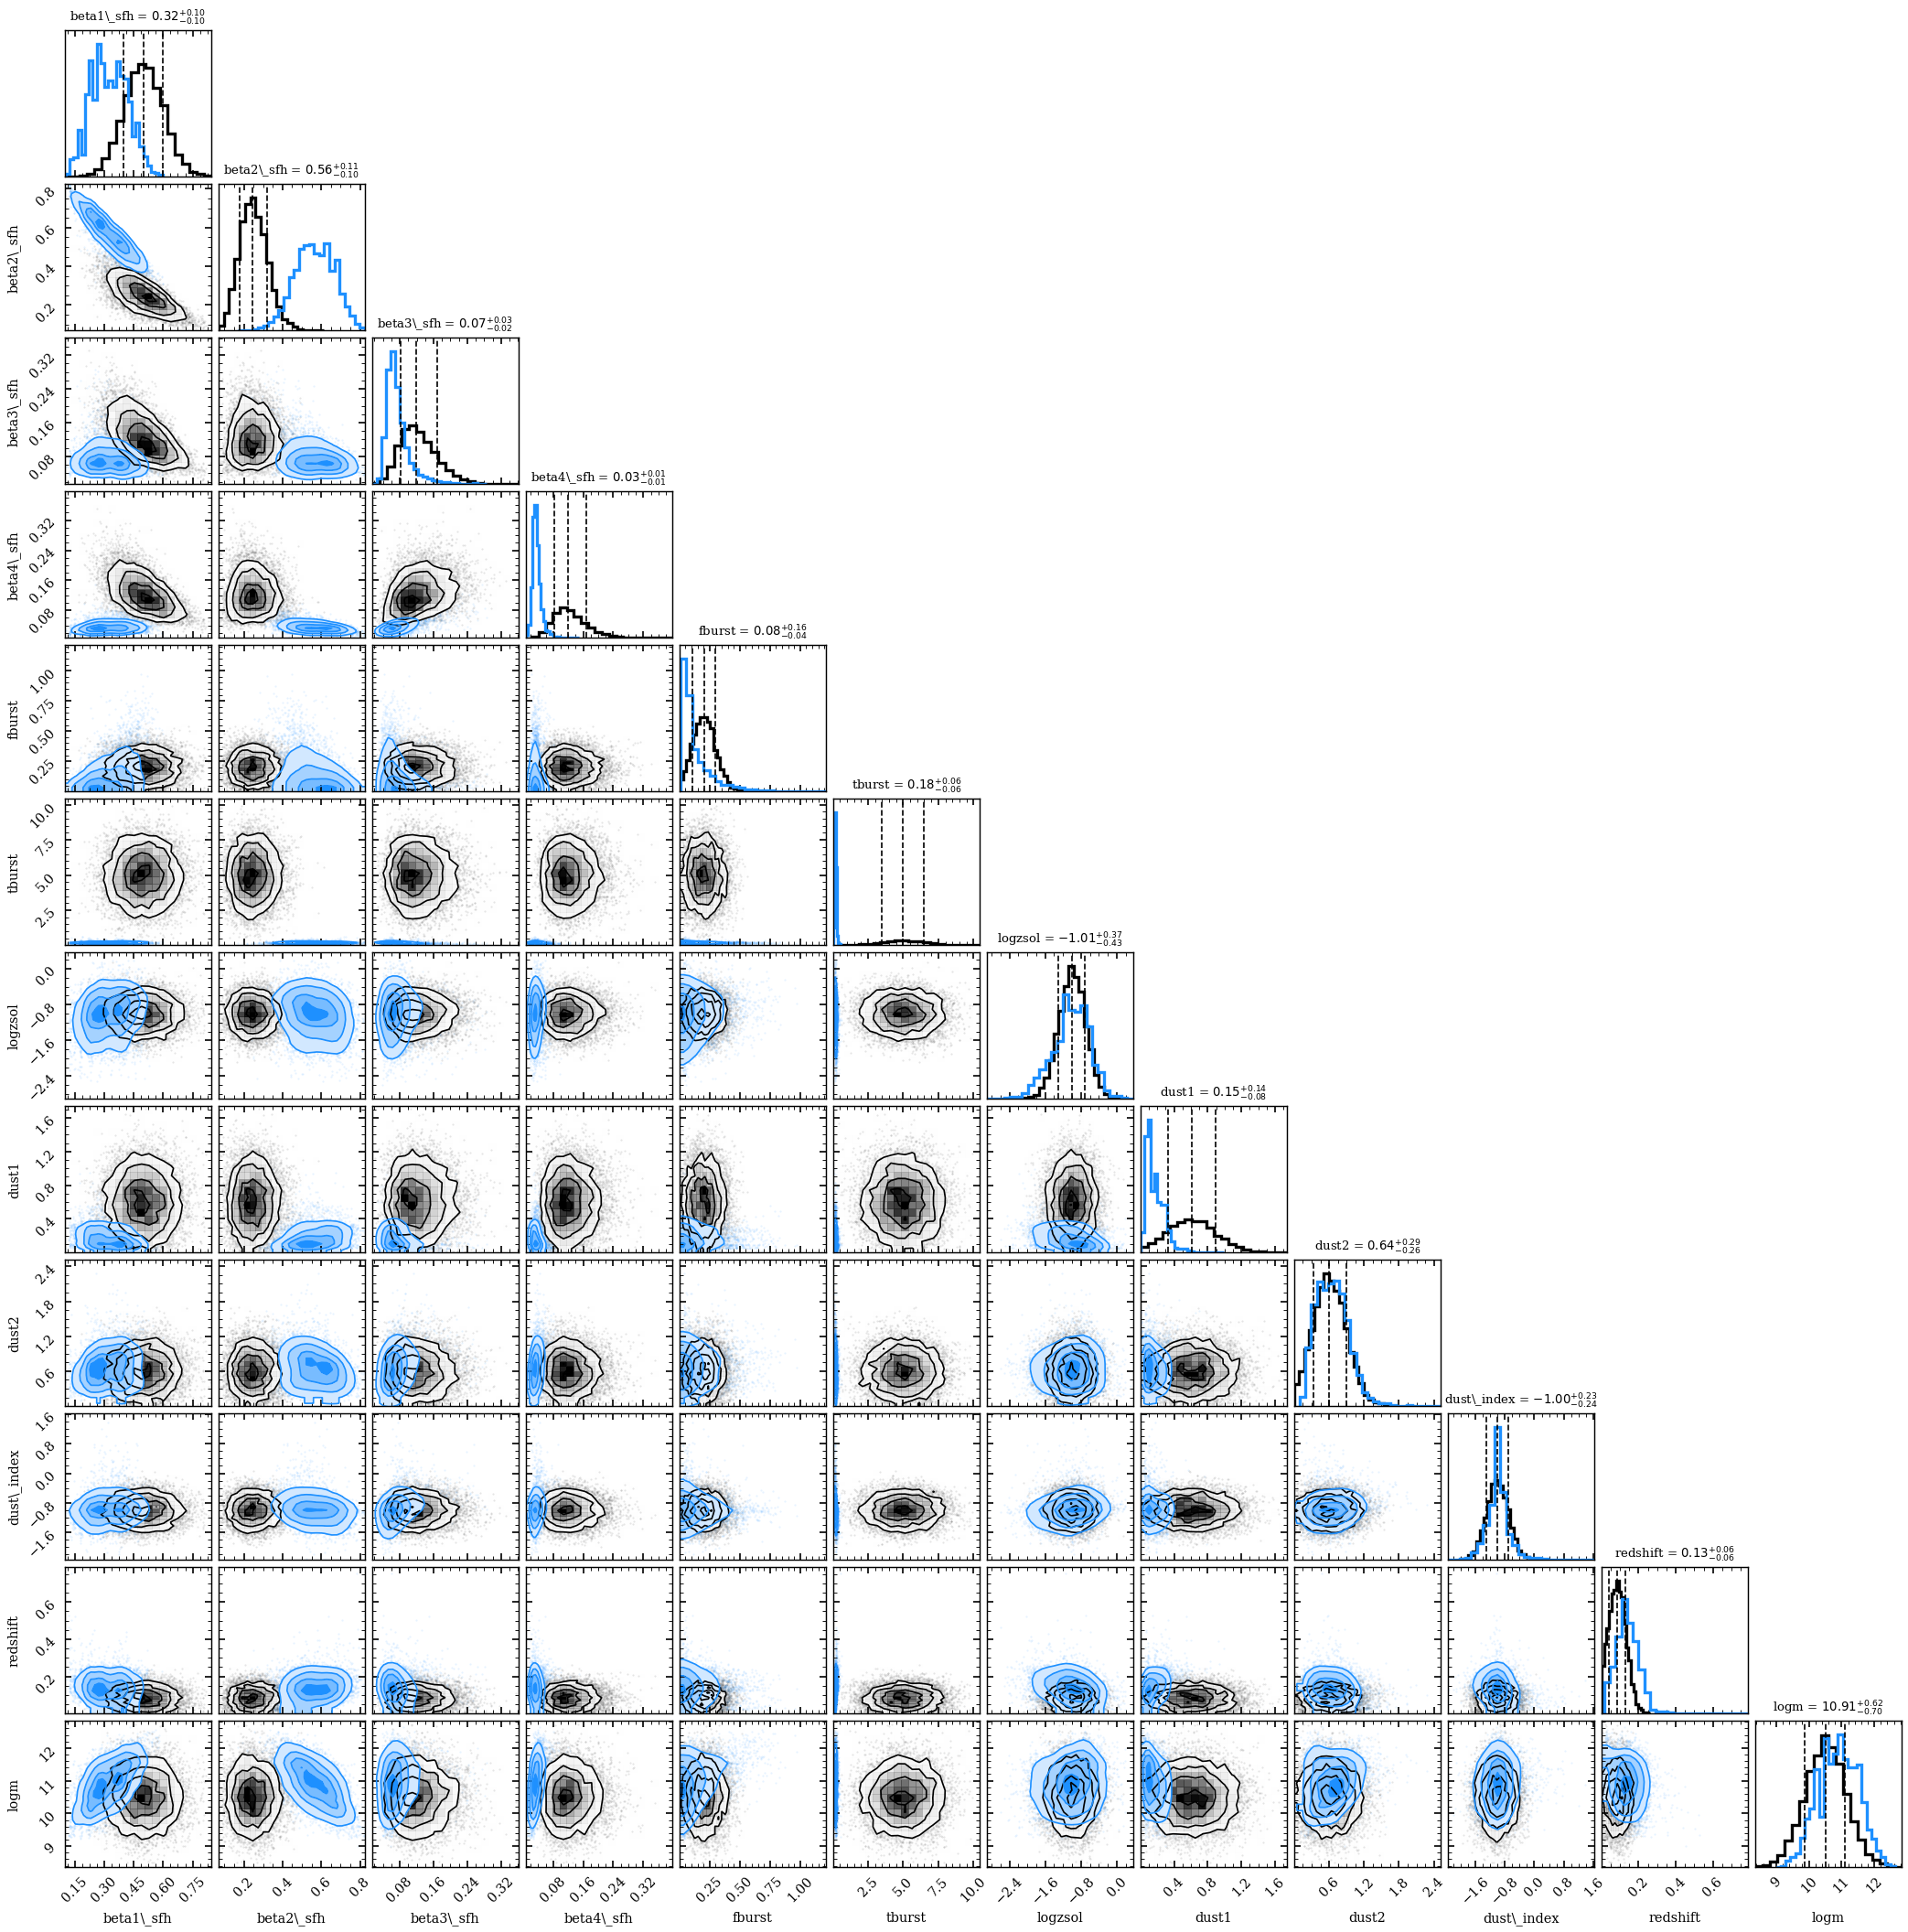

In [168]:
_labels = [f'beta{i}_sfh' for i in range(1,5)] + speculator.params_name[3:]
_labels = [key.replace('_', '\_') for key in _labels]


# Distribution of beta coeffs
y_truth_trans = np.hstack([_thetas[:, 1:], # params taken by emulator, including redshift (for t_age)
                           _thetas[:, 0:1], # stellar mass
                    ])

figure = corner.corner(y_truth_trans, 
                       quantiles=[0.16, 0.5, 0.84], 
                       labels=_labels,
                       smooth=0.3,
                       show_titles=True, 
                       title_kwargs={"fontsize": 12}, 
                       hist_kwargs={'density': True})

y_truth_trans = np.hstack([_samples[:, 1:], # params taken by emulator, including redshift (for t_age)
                           _samples[:, 0:1], # stellar mass
                    ])

nf_plot = corner.corner(y_truth_trans, 
                  fig=figure, labels=_labels, bins=25,
                  color='dodgerblue', #quantiles=[0.16, 0.5, 0.84], 
                  smooth=1, fill_contours=True,
                  show_titles=True, title_kwargs={"fontsize": 12}, 
                        hist_kwargs={'density': True})

# ax = nf_plot.get_axes()[1]
# ax.legend(handles=[k_line, b_line], fontsize=11.5, bbox_to_anchor=(0., 1.0, 1.3, .0))

In [142]:
NDE_theta.penalty_powers = [10] * 11

In [144]:
n_samples = len(NDE_theta.X.detach())

L = SamplesLoss(loss="sinkhorn", **{'p': 1, 'blur': 0.1, 'scaling': 0.8})


NDE_theta.optimizer.param_groups[0]['lr'] = 1e-6
NDE_theta.optimizer.zero_grad()
loss, bad_ratio = NDE_theta._get_loss_NMF(NDE_theta.X.detach(), speculator, n_samples,
                                 noise, None, noise_model_dir, L)
print(loss, bad_ratio)
loss.backward()
# NDE_theta.optimizer.step()
#     NDE_theta.sample(1)

Bad mask num tensor(3296, device='cuda:0')
Number of inf: tensor(0, device='cuda:0')
tensor(14.0700, device='cuda:0', grad_fn=<AddBackward0>) tensor(13.3888, device='cuda:0', grad_fn=<MeanBackward0>)


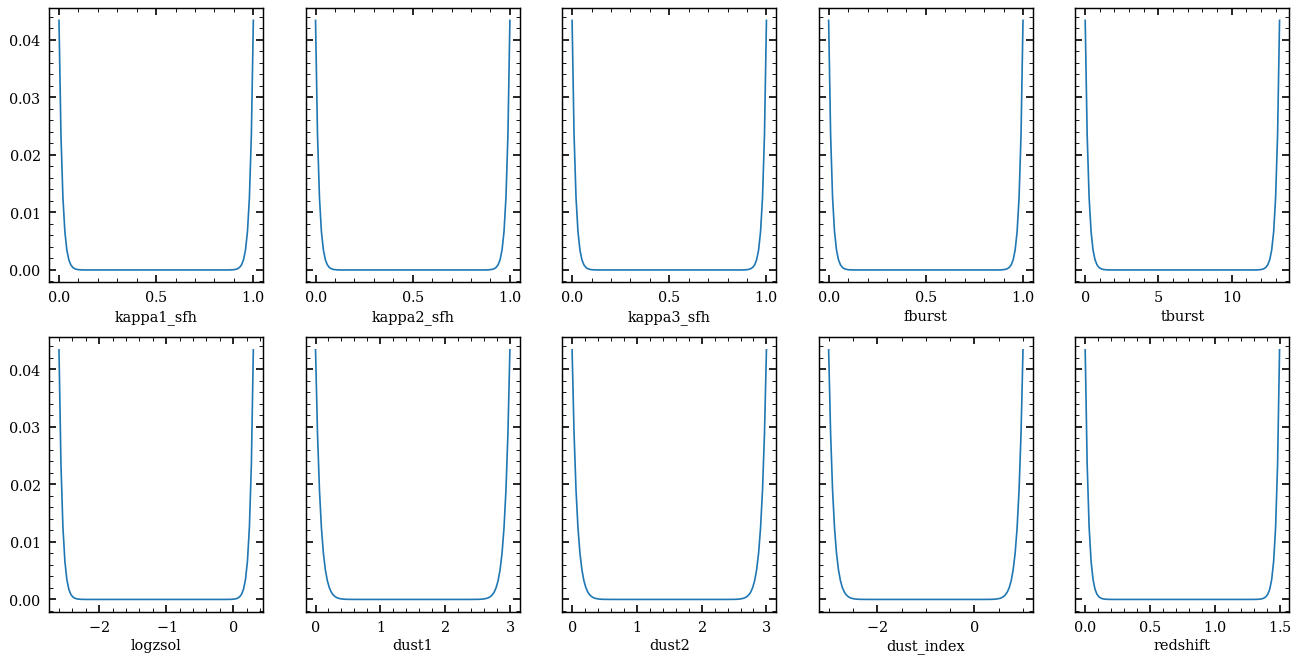

In [209]:
#### Plot the penalty

from popsed.nde import fuzzy_logic_prior

bounds = torch.Tensor(NDE_theta.bounds)

powers = NDE_theta.penalty_powers # [10] * 11
# [50] * 3 + [50] * 2 + [50] + [30] * 3 + [50] * 2
width = (bounds[:, 1] - bounds[:, 0]) / 2
loc = (bounds[:, 1] + bounds[:, 0]) / 2
index = torch.ones_like(loc) * 3

fig, axes = plt.subplots(2, 5, figsize=(20, 10), sharey=True)
for i in range(10):
    plt.sca(axes[i//5, i%5])
    par = torch.linspace(*bounds[i], 100)
    _penalty = fuzzy_logic_prior(par, loc[i], 10 ** (index[i] / powers[i]) * width[i], powers[i])
    plt.plot(par.cpu().numpy(), _penalty.cpu().numpy())
    plt.xlabel(NDE_theta.params_name[i])
    
plt.subplots_adjust(hspace=0.2)

kappa1_sfh, kappa2_sfh, kappa3_sfh, fburst, tburst, logzsol, dust1, dust2, dust_index, redshift, logmstar